## Convolutional Networks
-----------------------





Note: ensure that CUDA have been activated, otherwise training might take too long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [1]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


## Dataset Loading

The MNIST dataset of handwritten digits for categorical classification is used.

Following is a function that returns the training and the test set of MNIST, using the given transform.

In [2]:
import torch
import torchvision
import PIL

In [3]:
def datasets(transform):
  trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
  testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

  return trainset, testset

## Data Types

Create the dataset with `transform=None`. Check that all inputs are of type `PIL.Image.Image`, and all targets are integral.

In [4]:
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x,PIL.Image.Image)
  assert x.size == (28,28)
  # check datatype of target t
  assert isinstance(t,int) and 0<=t<=9
print("Data checking is finished successfully")

100%|██████████| 9912422/9912422 [00:19<00:00, 508489.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93830901.49it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32912441.81it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20374897.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data checking is finished successfully


## Data Loaders

Create the dataset with `transform=torchvision.transforms.ToTensor()`. Create two data loaders, one for the training set and one for the test set.

In [5]:
transform = torchvision.transforms.ToTensor()
trainset, testset = datasets(transform)

B = 64 # batch size
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=B)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=B)

## Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch. Check that all inputs and targets are of type `torch.Tensor`. Check that all input values are in range $[0,1]$. Check that all target values are in range $[0,9]$.

In [6]:
for i, (x, t) in enumerate(trainloader):
  # check datatype, size, and content of x
  assert type(x) == torch.Tensor
  assert torch.all(x >= 0) and torch.all(x <= 1)
  if (i != len(trainloader) - 1):
    assert len(x) == B

  # check datatype, size, and content of t
  assert type(t) == torch.Tensor
  assert torch.all(t >= 0) and torch.all(t <= 9)

## Fully-Connected Network

Implement a function that returns a three-layer fully-connected network in pytorch.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A `torch.nn.Flatten` layer to turn the $28\times28$ pixel image (2D) into a $28*28$ pixel vector (1D)
2. A fully-connected layer with D input neurons and K outputs.
3. A $\tanh$ activation function.
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [7]:
def fully_connected(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(D,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,K),
    torch.nn.Tanh(),
    torch.nn.Linear(K,O),
  )

## Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. 2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. 2D maximum pooling with pooling size $2\times2$ and stride 2
3. $\tanh$ activation
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. 2D maximum pooling with pooling size $2\times2$ and stride 2
6. $\tanh$ activation
7. A flattening layer to turn the 3D image into 1D vector
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [8]:
def convolutional(Q1, Q2, O):
  return torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size = (5,5), stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
    torch.nn.Tanh(),
    torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size = (5,5), stride=1, padding=2),
    torch.nn.MaxPool2d(kernel_size=(2,2), stride=2),
    torch.nn.Tanh(),
    torch.nn.Flatten(),
    torch.nn.Linear(Q2*7*7, O)
  )


## Training and Validation Loop

Implement a function that takes the network, the number of epochs and the learning rate.
Select the correct loss function for categorical classification, and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data
2. Compute the test set loss and test set accuracy
3. Store both in a vector

Finally, return the lists of validation losses and accuracies.

In [9]:
def train(network, epochs=10, eta=0.01):
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params=network.parameters(), lr=eta)

  # instantiate the correct device
  device = torch.device("cuda")
  network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []

  for epoch in range(epochs):
    # train network on training data
    for x,t in trainloader:
      optimizer.zero_grad()
      x = x.to(device)
      t = t.to(device)
      z = network(x)
      J = loss(z, t)
      J.backward()
      optimizer.step()

    # test network on test data
    with torch.no_grad():
      correct = 0
      test_loss = []
      for x,t in testloader:
        z = network(x.to(device))
        J = loss(z, t.to(device))
        # compute test accuracy
        correct += torch.sum(torch.argmax(z, dim=1) == t.to(device)).item()
        test_loss.append(J.item())
      acc = correct / len(testset)
      val_loss.append(sum(test_loss) / len(test_loss))
      val_acc.append(acc)

  # return loss and accuracy values
  return val_loss, val_acc

## Fully-Connected Training

Create a fully-connected network with $K=10$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$ and store the obtained test losses and accuracies.

In [10]:
fc = fully_connected(28 * 28, 10, 10)
fc_loss, fc_acc = train(fc)

## Convolutional Training

Create a convolutional network with $Q_1=32$ and $Q_2=64$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$ and store the obtained test losses and accuracies.

In [11]:
cv = convolutional(Q1=32, Q2=64, O=10)
cv_loss, cv_acc = train(cv)

## Plotting

Plot the two lists of loss values in one figure, and the two lists of accuracy values in another figure.

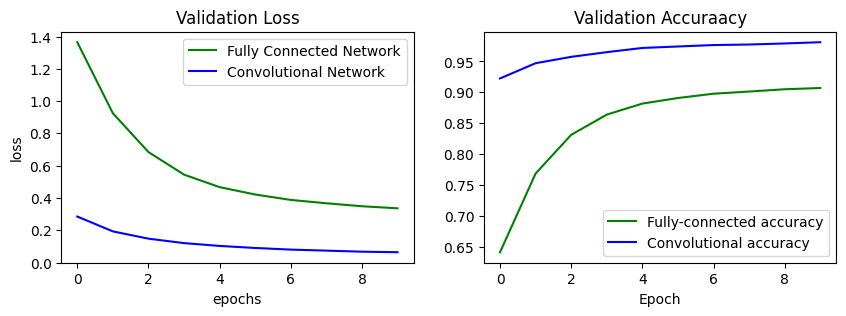

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,3))
ax = plt.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(fc_loss, "g-", label="Fully Connected Network")
ax.plot(cv_loss, "b-", label="Convolutional Network")
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend()
ax.set_title('Validation Loss')

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(fc_acc, "g-", label="Fully-connected accuracy")
ax.plot(cv_acc, "b-", label="Convolutional accuracy")
ax.set_xlabel("Epoch")
ax.legend()
ax.set_title('Validation Accuraacy')
plt.show()

## Learnable Parameters

Estimate how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.
The number of parameters in the networks is computed by summing the number of parameters in each layer using `numel()` function from a `torch.Tensor`.

Fully connected network:
- The first layer and second layer: there are (28x28+1) x 10 = 7850 parameters
- The second layer and third layer: there are (10+1) x 10 = 110 parameters
- The second layer and output layer: there are (10+1) x 10 = 110 parameters
\
 In total, 7850 + 110 + 110 = 8070 parameters

For convolutional network:
- The first convolutional layer: there are (5x5+1) x 32 = 832 parameters
- The second convolutional layer: there are (5x5x32+1) x 64 = 51264 parameters
- Flattened layer and output layer: there are (7x7x64+1) x 10 = 31370 parameters
\
In total, 832 + 51264 + 31370 = 83466 parameters

In [14]:
def parameter_count(network):
  return sum(p.numel() for p in network.parameters())

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 8070
Convolutional Network: 83466
